In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # CUDA 11.1
# !pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

In [ ]:
# RMSE -> MAE Loss 꿀팁!!

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3, 4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/module'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Jun  3 02:36:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   27C    P0    24W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   

## Setup imports

In [2]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    RandFlipd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-134-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.51.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [3]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [4]:
train_n_20_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/20/*/*/*.npy'))
train_n_40_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/40/*/*/*.npy'))
train_n_60_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/60/*/*/*.npy'))
train_n_80_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/80/*/*/*.npy'))
train_high_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/X/*/*/*.npy'))

valid_n_20_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Valid/*/20/*/*/*.npy'))
valid_n_40_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Valid/*/40/*/*/*.npy'))
valid_n_60_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Valid/*/60/*/*/*.npy'))
valid_n_80_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Valid/*/80/*/*/*.npy'))
valid_high_images   = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Valid/*/X/*/*/*.npy'))

total_n_20_images   = train_n_20_images   + valid_n_20_images
total_n_40_images   = train_n_40_images   + valid_n_40_images
total_n_60_images   = train_n_60_images   + valid_n_60_images
total_n_80_images   = train_n_80_images   + valid_n_80_images
total_high_images   = train_high_images   + valid_high_images

train_files = [{"n_20": n_20, "n_40": n_40, "n_60": n_60, "n_80": n_80, "high": high} for n_20, n_40, n_60, n_80, high in zip(total_n_20_images, total_n_40_images, total_n_60_images, total_n_80_images, total_high_images)]

## Augmentation

In [5]:
def MinMax_Normalize(x):
    x -= x.min()
    x /= x.max()
    return x

In [6]:
# CT에 맞는 Augmentation
from torchvision import transforms
train_transforms = Compose(
    [
        LoadNumpyd(keys=["n_20", "n_40", "n_60", "n_80", "high"]),
        AddChanneld(keys=["n_20", "n_40", "n_60", "n_80", "high"]), 
        
#         RandSpatialCropd(keys=["n_20", "n_40", "n_60", "n_80", "high"], roi_size=(320, 320), random_center=True, random_size=False),
#         RandFlipd(keys=["n_20", "n_40", "n_60", "n_80", "high"], prob=0.5, spatial_axis=1), # Horizon Flip
        
        ToTensord(keys=["n_20", "n_40", "n_60", "n_80", "high"]),
        
#         Lambdad(keys=["n_20", "n_40", "n_60", "n_80"], func=MinMax_Normalize),
#         Lambdad(keys=["n_20", "n_40", "n_60", "n_80", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [7]:
def visual_windowing_V2(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

image shape: torch.Size([512, 512])


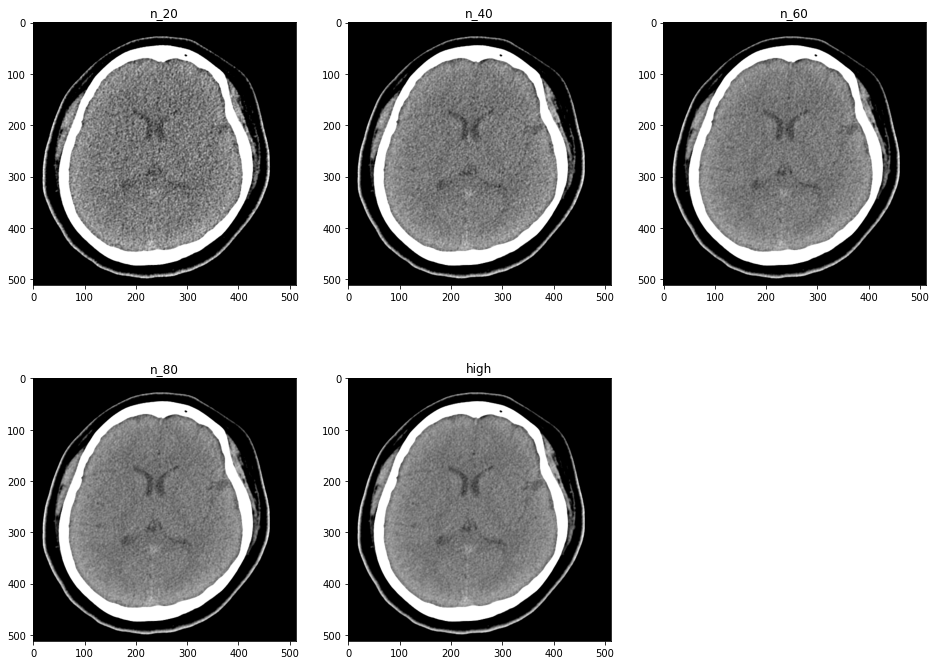

In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[142]

n_20 = (check_data["n_20"][0])
n_40 = (check_data["n_40"][0])
n_60 = (check_data["n_60"][0])
n_80 = (check_data["n_80"][0])
high = (check_data["high"][0])
print(f"image shape: {n_20.shape}")

plt.figure("check", (16, 12))

plt.subplot(2, 3, 1)
plt.title("n_20")
plt.imshow(visual_windowing_V2(n_20), cmap="gray")

plt.subplot(2, 3, 2)
plt.title("n_40")
plt.imshow(visual_windowing_V2(n_40), cmap="gray")

plt.subplot(2, 3, 3)
plt.title("n_60")
plt.imshow(visual_windowing_V2(n_60), cmap="gray")

plt.subplot(2, 3, 4)
plt.title("n_80")
plt.imshow(visual_windowing_V2(n_80), cmap="gray")

plt.subplot(2, 3, 5)
plt.title("high")
plt.imshow(visual_windowing_V2(high), cmap="gray")

plt.show()

## DataLoader

In [9]:
import multiprocessing
# from torchsampler.imbalanced import ImbalancedDatasetSampler, sunggu_ImbalancedDatasetSampler

# cf) use batch_size=2 to load images and use RandCropByPosNegLabeld
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, drop_last=True)

CPU 갯수 =  32


## Create Model, Loss, Optimizer  Only Low -> High

In [10]:
from utils.Unet_sunggu.model import Enhance_UNet

class Seqeunce_UNet(torch.nn.Module):
    def __init__(self):
        super(Seqeunce_UNet, self).__init__()        
        self.unet = Enhance_UNet(input_nc=1, output_nc=1)

    def forward(self, noise_20, noise_40, noise_60, noise_80):
        # noise 20이 noise 40보다 더 noise가 심함.
        pred_noise_40, feat_n_40 = self.unet(noise_20)
        pred_noise_60, feat_n_60 = self.unet(noise_40)
        pred_noise_80, feat_n_80 = self.unet(noise_60)
        pred_high,     feat_high = self.unet(noise_80)
        
        return pred_noise_40, pred_noise_60, pred_noise_80, pred_high

    def inferece(self, noise_20):
        # noise 20이 noise 40보다 더 noise가 심함.
        pred_noise_40, feat_n_40 = self.unet(noise_20)
        pred_noise_60, feat_n_60 = self.unet(pred_noise_40)
        pred_noise_80, feat_n_80 = self.unet(pred_noise_60)
        pred_high,     feat_high = self.unet(pred_noise_80)
        
#         return pred_noise_40, pred_noise_60, pred_noise_80, pred_high, feat_n_40, feat_n_60, feat_n_80, feat_high
        return pred_noise_40, pred_noise_60, pred_noise_80, pred_high
    
device = 'cuda'
model  = Seqeunce_UNet()      

## 모델 이어서 학습하기

In [11]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/[SequenceUnet]Dose Unet_with_Perceptual-Sinogram/epoch_94_model.pth'
checkpoint = torch.load(checkpoint_dir)

model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
print(epoch)

94


## Multi-GPU 및 손실함수 정의하기

In [12]:
from torchvision import models
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)        
        h_relu3 = self.slice3(h_relu2)        
        h_relu4 = self.slice4(h_relu3)        
        h_relu5 = self.slice5(h_relu4)                
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out
    
class VGGLoss(torch.nn.Module):
    def __init__(self, device):
        super(VGGLoss, self).__init__()        
        self.vgg = Vgg19().to(device)
        self.criterion = torch.nn.L1Loss()
        self.weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]        

    def forward(self, x, y):              
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())        
        return loss

In [13]:
from module.loss import MS_SSIM_L1_LOSS

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)

model.to(device)    

# Define loss functions
# L1_loss            = torch.nn.L1Loss()
Perceptual_loss      = VGGLoss(device='cuda')
MS_SSIM_L1_loss      = MS_SSIM_L1_LOSS(gaussian_sigmas=[0.5, 1.0, 2.0, 4.0, 8.0], data_range=1.0, K=(0.01, 0.03), alpha=0.84, compensation=200.0)
# Triplet_margin_loss  = nn.TripletMarginLoss(margin=1.0, p=2) # shape must be (B, C)


learning_rate = 2e-4
max_epochs = 1000


# def lambda_rule(epoch, start_decay_epoch=50, total_epoch=max_epochs):
#     lr = 1.0 - max(0, epoch - start_decay_epoch) / float(total_epoch)
#     return lr

def lambda_rule(epoch, warm_up_epoch=10, start_decay_epoch=max_epochs/10, total_epoch=max_epochs):
    # Linear WarmUP
    if (epoch < warm_up_epoch):
        return max(0, epoch / warm_up_epoch)
    else :
        lr = 1.0 - max(0, epoch - start_decay_epoch) /(float(total_epoch) - start_decay_epoch)
    return lr

# Optimizer 설정하기
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

Let's use 2 GPUs!


In [14]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler.load_state_dict(checkpoint['scheduler'])        

In [15]:
print(checkpoint['epoch'])

94


## Train

In [16]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy        = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm_window  = visual_windowing_V2

In [17]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
epoch_num = max_epochs
val_interval = 5

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/[SequenceUnet]Dose Unet_with_Perceptual-Sinogram')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/[SequenceUnet]Dose Unet_with_Perceptual-Sinogram/'
low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'[SequenceUnet]Dose Unet_with_Perceptual-Sinogram'+'/low2high/'

# 모델 save폴더 만들기
os.makedirs(root_dir, mode=0o777, exist_ok=True)
os.makedirs(low2high_png_dir, mode=0o777, exist_ok=True)

for epoch in range(94, epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    model.train()    
    
    # Loss 선언    
    loss_total_train   = []
    loss_n_40_train    = []
    loss_n_60_train    = []
    loss_n_80_train    = []
    loss_high_train    = []
     
        
    train_iterator = tqdm(train_loader, desc='Train', file=sys.stdout)    
    for batch_data in train_iterator:
        
        input_n_20  = batch_data['n_20'].to(device)
        input_n_40  = batch_data['n_40'].to(device)
        input_n_60  = batch_data['n_60'].to(device)
        input_n_80  = batch_data['n_80'].to(device)
        input_high  = batch_data['high'].to(device)
        
        # Generate fake
#         pred_noise_40, pred_noise_60, pred_noise_80, pred_high, feat_n_40, feat_n_60, feat_n_80, feat_high = model(input_n_20, input_n_40, input_n_60, input_n_80)    
        pred_noise_40, pred_noise_60, pred_noise_80, pred_high = model(input_n_20, input_n_40, input_n_60, input_n_80)    

        optimizer.zero_grad()

        # Loss 
        loss_n_40 = Perceptual_loss(pred_noise_40.repeat(1,3,1,1), input_n_40.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_noise_40, input_n_40)
        loss_n_60 = Perceptual_loss(pred_noise_60.repeat(1,3,1,1), input_n_60.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_noise_60, input_n_60)
        loss_n_80 = Perceptual_loss(pred_noise_80.repeat(1,3,1,1), input_n_80.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_noise_80, input_n_80)
        loss_high = Perceptual_loss(pred_high.repeat(1,3,1,1),     input_high.repeat(1,3,1,1)) + MS_SSIM_L1_loss(pred_high,     input_high)
        
#         Triplet_loss = Triplet_margin_loss(anchor=feat_high, positive=feat_n_80, negative=feat_n_40)+\
#                        Triplet_margin_loss(anchor=feat_high, positive=feat_n_80, negative=feat_n_60)+\
#                        Triplet_margin_loss(anchor=feat_high, positive=feat_n_60, negative=feat_n_40)
#         total_loss = loss_n_40 + loss_n_60 + loss_n_80 + loss_high + Triplet_loss

        total_loss = loss_n_40 + loss_n_60 + loss_n_80 + loss_high
        total_loss.backward()
        optimizer.step()
        
        # 기록        
        loss_total_train  += [total_loss.item()]
        loss_n_40_train   += [loss_n_40.item()]
        loss_n_60_train   += [loss_n_60.item()]
        loss_n_80_train   += [loss_n_80.item()]
        loss_high_train   += [loss_high.item()]
        
        
    print( "Loss       [Total Loss]       = %.4f" %np.mean(loss_total_train) ) 
    print( "Loss       [Noise_40 Loss]    = %.4f" %np.mean(loss_n_40_train) ) 
    print( "Loss       [Noise_60 Loss]    = %.4f" %np.mean(loss_n_60_train) ) 
    print( "Loss       [Noise_80 Loss]    = %.4f" %np.mean(loss_n_80_train) ) 
    print( "Loss       [High Loss]        = %.4f" %np.mean(loss_high_train) ) 
    
    # Tensorboard 저장하기
    input_n_20   = fn_denorm_window(fn_tonumpy((input_n_20)))
    input_n_40   = fn_denorm_window(fn_tonumpy((input_n_40)))
    input_n_60   = fn_denorm_window(fn_tonumpy((input_n_60)))
    input_n_80   = fn_denorm_window(fn_tonumpy((input_n_80)))
    input_high   = fn_denorm_window(fn_tonumpy((input_high)))
    
    pred_noise_40  = fn_denorm_window(fn_tonumpy((pred_noise_40)))
    pred_noise_60  = fn_denorm_window(fn_tonumpy((pred_noise_60)))
    pred_noise_80  = fn_denorm_window(fn_tonumpy((pred_noise_80)))
    pred_high      = fn_denorm_window(fn_tonumpy((pred_high)))

    input_n_20   = np.clip(input_n_20, a_min=0, a_max=1)
    input_n_40   = np.clip(input_n_40, a_min=0, a_max=1)
    input_n_60   = np.clip(input_n_60, a_min=0, a_max=1)
    input_n_80   = np.clip(input_n_80, a_min=0, a_max=1)
    input_high   = np.clip(input_high, a_min=0, a_max=1)
    
    pred_noise_40 = np.clip(pred_noise_40, a_min=0, a_max=1)
    pred_noise_60 = np.clip(pred_noise_60, a_min=0, a_max=1)
    pred_noise_80 = np.clip(pred_noise_80, a_min=0, a_max=1)
    pred_high     = np.clip(pred_high,     a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_20.png',   input_n_20[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_40.png',   input_n_40[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_60.png',   input_n_60[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_n_80.png',   input_n_80[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_high.png',   input_high[0].squeeze(),  cmap="gray")
    
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_noise_40.png', pred_noise_40[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_noise_60.png', pred_noise_60[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_noise_80.png', pred_noise_80[0].squeeze(),  cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_pred_high.png',     pred_high[0].squeeze(),      cmap="gray")
   

    # Loss Write
    
    print( "Loss       [Total Loss]       = %.4f" %np.mean(loss_total_train) ) 
    print( "Loss       [Noise_40 Loss]    = %.4f" %np.mean(loss_n_40_train) ) 
    print( "Loss       [Noise_60 Loss]    = %.4f" %np.mean(loss_n_60_train) ) 
    print( "Loss       [Noise_80 Loss]    = %.4f" %np.mean(loss_n_80_train) ) 
    print( "Loss       [High Loss]        = %.4f" %np.mean(loss_high_train) ) 
    
    writer.add_scalar('Train/loss_total',  np.mean(loss_total_train), epoch)
    writer.add_scalar('Train/loss_n_40',   np.mean(loss_n_40_train),  epoch)
    writer.add_scalar('Train/loss_n_60',   np.mean(loss_n_60_train),  epoch)
    writer.add_scalar('Train/loss_n_80',   np.mean(loss_n_80_train),  epoch)
    writer.add_scalar('Train/loss_high',   np.mean(loss_high_train),  epoch)
    
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'model_state_dict': model.module.state_dict(), 
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'model_state_dict': model.state_dict(), 
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                         }                         

        torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
        
    # Scheduler
    writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
    old_lr = optimizer.param_groups[0]['lr']
    lr     = optimizer.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))
    scheduler.step()     
    
writer.close()    


----------
epoch 94/1000
Train: 100%|██████████| 1724/1724 [1:25:36<00:00,  2.98s/it]
Loss       [Total Loss]       = 3.9788
Loss       [Noise_40 Loss]    = 2.0003
Loss       [Noise_60 Loss]    = 1.1007
Loss       [Noise_80 Loss]    = 0.6049
Loss       [High Loss]        = 0.2730
Loss       [Total Loss]       = 3.9788
Loss       [Noise_40 Loss]    = 2.0003
Loss       [Noise_60 Loss]    = 1.1007
Loss       [Noise_80 Loss]    = 0.6049
Loss       [High Loss]        = 0.2730
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 95/1000
Train: 100%|██████████| 1724/1724 [1:25:47<00:00,  2.99s/it]
Loss       [Total Loss]       = 4.0138
Loss       [Noise_40 Loss]    = 2.0085
Loss       [Noise_60 Loss]    = 1.1094
Loss       [Noise_80 Loss]    = 0.6137
Loss       [High Loss]        = 0.2821
Loss       [Total Loss]       = 4.0138
Loss       [Noise_40 Loss]    = 2.0085
Loss       [Noise_60 Loss]    = 1.1094
Loss       [Noise_80 Loss]    = 0.6137
Loss       [High Loss]        = 0.2821
Learn

Train: 100%|██████████| 1724/1724 [1:25:24<00:00,  2.97s/it]
Loss       [Total Loss]       = 3.9578
Loss       [Noise_40 Loss]    = 1.9863
Loss       [Noise_60 Loss]    = 1.0970
Loss       [Noise_80 Loss]    = 0.6040
Loss       [High Loss]        = 0.2706
Loss       [Total Loss]       = 3.9578
Loss       [Noise_40 Loss]    = 1.9863
Loss       [Noise_60 Loss]    = 1.0970
Loss       [Noise_80 Loss]    = 0.6040
Loss       [High Loss]        = 0.2706
Learning Rate 0.0001977778 -> 0.0001977778
----------
epoch 111/1000
Train: 100%|██████████| 1724/1724 [1:25:21<00:00,  2.97s/it]
Loss       [Total Loss]       = 3.9301
Loss       [Noise_40 Loss]    = 1.9791
Loss       [Noise_60 Loss]    = 1.0907
Loss       [Noise_80 Loss]    = 0.5972
Loss       [High Loss]        = 0.2631
Loss       [Total Loss]       = 3.9301
Loss       [Noise_40 Loss]    = 1.9791
Loss       [Noise_60 Loss]    = 1.0907
Loss       [Noise_80 Loss]    = 0.5972
Loss       [High Loss]        = 0.2631
Learning Rate 0.0001975556 ->

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-26c550222458>", line 58, in <module>
    total_loss.backward()
  File "/home/sunggu/.local/lib/python3.6/site-packages/torch/tensor.py", line 245, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/home/sunggu/.local/lib/python3.6/site-packages/torch/autograd/__init__.py", line 147, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'


TypeError: object of type 'NoneType' has no len()

In [18]:
if torch.cuda.device_count() > 1:
    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.module.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                 }                    

else:
    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                 }                         

torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))    

## TEST

In [ ]:
#     with torch.no_grad():
#         netG.eval()
#         netD.eval()

#         loss_G_gan_valid  = []
#         loss_G_L1_valid   = []
#         loss_D_real_valid = []
#         loss_D_fake_valid = []
        
#         valid_iterator = tqdm(valid_loader, desc='Valid', file=sys.stdout)    
#         for batch_data in valid_iterator:
        
#             input_low  = batch_data['low'].to(device)
#             input_high = batch_data['high'].to(device)
            
#             output = netG(input_low)

#             real = torch.cat([input_low, input_high], dim=1)
#             fake = torch.cat([input_low, output], dim=1)      
            
#             # D
#             pred_real = netD(real)        
#             pred_fake = netD(fake.detach())

#             loss_D_real = gan_loss(pred_real, torch.ones_like(pred_real))
#             loss_D_fake = gan_loss(pred_fake, torch.zeros_like(pred_fake))

#             # G
#             pred_fake = netD(fake)        
            
#             loss_G_gan = gan_loss(pred_fake, torch.ones_like(pred_fake))
#             loss_G_L1  = L1_loss(output, input_high)

#             # 기록
#             loss_D_real_valid += [loss_D_real.item()]
#             loss_D_fake_valid += [loss_D_fake.item()]
#             loss_G_gan_valid  += [loss_G_gan.item()]
#             loss_G_L1_valid   += [loss_G_L1.item()]
        
        
#     print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_valid) ) 
#     print( "Generator Loss       [L1  Loss]    = %.4f" %np.mean(loss_G_L1_valid) ) 
#     print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_valid) )
#     print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_valid) )

    
#     # Tensorboard 저장하기
#     input_low   = fn_denorm(fn_tonumpy((input_low)))
#     input_high  = fn_denorm(fn_tonumpy((input_high)))
#     output = fn_denorm(fn_tonumpy((output)))

#     input_low   = np.clip(input_low, a_min=0, a_max=1)
#     input_high  = np.clip(input_high, a_min=0, a_max=1)
#     output = np.clip(output, a_min=0, a_max=1)

#     # png Save
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(), cmap="gray")
#     plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
#     # Loss Write    
#     writer.add_scalar('Valid/loss_G_gan',  np.mean(loss_G_gan_valid), epoch)
#     writer.add_scalar('Valid/loss_G_L1',   np.mean(loss_G_L1_valid), epoch)
#     writer.add_scalar('Valid/loss_D_real', np.mean(loss_D_real_valid), epoch)
#     writer.add_scalar('Valid/loss_D_fake', np.mean(loss_D_fake_valid), epoch)

    
#     # 저장
#     if epoch % 5 == 0 or epoch == epoch_num:

#         if torch.cuda.device_count() > 1:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.module.state_dict(), 
#                           'netD_state_dict': netD.module.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),  
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                    

#         else:
#             checkpoint = {'epoch': epoch, 
#                           'netG_state_dict': netG.state_dict(), 
#                           'netD_state_dict': netD.state_dict(), 
#                           'optimizer_G_state_dict': optimizer_G.state_dict(),
#                           'optimizer_D_state_dict': optimizer_D.state_dict(),
#                           'scheduler_G': scheduler_G.state_dict(),
#                           'scheduler_D': scheduler_D.state_dict(),
#                          }                         

#             torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
#     # Scheduler
#     writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
#     old_lr = optimizer_G.param_groups[0]['lr']
#     lr = optimizer_G.param_groups[0]['lr']
#     print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

#     scheduler_G.step()    
#     scheduler_D.step()    

# writer.close()

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)